# Cognitive Memory Agent - Benchmark Demo

**Does episodic/procedural/consolidation memory actually help, or is vanilla RAG enough?**

This notebook runs a structured benchmark comparing two agents:

| Agent | Memory Systems | Purpose |
|-------|---------------|----------|
| **Baseline** (semantic_only) | Working + Semantic (RAG) | Standard retrieval-augmented generation |
| **Full** | Working + Semantic + Episodic + Procedural + Consolidation | Cognitive memory architecture |

All tests use a **5-page synthetic PDF** about a fictional company (Zeltron Corporation). Since Claude has never seen this data in training, correct answers **prove** the memory systems work.

### Sections

| # | Section | What it tests | Expected outcome |
|---|---------|--------------|------------------|
| 1 | **Semantic Retrieval** | 12 factual questions (easy/medium/hard) using RAG over the PDF | Both agents score similarly - episodic memory is irrelevant for pure fact lookup |
| 2 | **Episodic Memory** | 3 multi-turn conversations plant user-specific details, then 4 recall questions ask about them | Full agent recalls conversation history; baseline scores ~0 (no memory of past chats) |
| 3 | **Consolidation** | Overlapping episodes are built, then a sleep phase merges similar ones and promotes rules | Episodes compress, procedural rules grow |
| 4 | **Post-Consolidation Recall** | 2 synthesis questions requiring themes across multiple past conversations | Full agent synthesizes across consolidated memories; baseline cannot |
| 5 | **Integration Demo** | One complex query activates all 5 memory systems, showing each contribution | Full agent produces a personalized response using semantic + episodic + procedural context |
| 6 | **Scorecard** | Side-by-side comparison table + dashboard | Clear gap on episodic/synthesis tasks, parity on semantic tasks |

In [1]:
import os, sys, json, shutil, time, textwrap, re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from IPython.display import display, Markdown, HTML
from dotenv import load_dotenv

# Load API key from .env
load_dotenv()
assert os.environ.get('ANTHROPIC_API_KEY'), 'Set ANTHROPIC_API_KEY in .env or env var before running'

# Clean slate
for path in ['chroma_db', 'procedural_memory.txt']:
    if os.path.isdir(path):
        shutil.rmtree(path)
    elif os.path.isfile(path):
        os.remove(path)

os.makedirs('eda', exist_ok=True)


def show_chat(question, response, label='', agent_name='Agent'):
    """Display a chat exchange with styled HTML."""
    badge = ''
    if label:
        if 'PASS' in label.upper():
            badge_color = '#27ae60'
        elif 'FAIL' in label.upper():
            badge_color = '#e74c3c'
        elif 'PARTIAL' in label.upper():
            badge_color = '#f39c12'
        else:
            badge_color = '#7f8c8d'
        badge = f'<span style="background:{badge_color};color:white;padding:2px 8px;border-radius:4px;font-size:12px;font-weight:bold;">{label}</span> '

    # Escape HTML in response but preserve newlines
    resp_escaped = response.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;')
    resp_html = resp_escaped.replace('\n', '<br>')

    html = f"""
    <div style="margin:10px 0;">
        {badge}
        <div style="border-left:3px solid #3498db;padding:8px 12px;margin:6px 0;background:#f0f7ff;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">User:</strong> {question}
        </div>
        <div style="border-left:3px solid #27ae60;padding:8px 12px;margin:6px 0;background:#f0fff0;border-radius:0 4px 4px 0;">
            <strong style="color:#2c3e50;">{agent_name}:</strong><br>{resp_html}
        </div>
    </div>
    """
    display(HTML(html))


def show_comparison(question, baseline_resp, full_resp, baseline_pass, full_pass, label=''):
    """Show baseline vs full agent side by side."""
    def badge(passed):
        if passed:
            return '<span style="background:#27ae60;color:white;padding:2px 6px;border-radius:3px;font-size:11px;">PASS</span>'
        return '<span style="background:#e74c3c;color:white;padding:2px 6px;border-radius:3px;font-size:11px;">FAIL</span>'

    b_escaped = baseline_resp.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>')
    f_escaped = full_resp.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>')

    tag = f'<div style="color:#7f8c8d;font-size:11px;margin-bottom:4px;">{label}</div>' if label else ''

    html = f"""
    <div style="margin:12px 0;border:1px solid #ddd;border-radius:6px;overflow:hidden;">
        {tag}
        <div style="background:#f8f9fa;padding:8px 12px;border-bottom:1px solid #ddd;">
            <strong>Q:</strong> {question}
        </div>
        <div style="display:flex;gap:0;">
            <div style="flex:1;padding:8px 12px;border-right:1px solid #eee;">
                <div style="font-size:11px;color:#7f8c8d;margin-bottom:4px;">BASELINE (RAG only) {badge(baseline_pass)}</div>
                <div style="font-size:13px;">{b_escaped}</div>
            </div>
            <div style="flex:1;padding:8px 12px;">
                <div style="font-size:11px;color:#7f8c8d;margin-bottom:4px;">FULL AGENT {badge(full_pass)}</div>
                <div style="font-size:13px;">{f_escaped}</div>
            </div>
        </div>
    </div>
    """
    display(HTML(html))


print('Environment ready.')

Environment ready.


---
## 0. Initialize Both Agents

In [2]:
from agent import CognitiveAgent

# Initialize both agents (they share the same ChromaDB for semantic memory)
full_agent = CognitiveAgent(mode='full')
baseline_agent = CognitiveAgent(mode='semantic_only')

display(HTML(f"""
<table style='border-collapse:collapse;margin:12px 0;'>
<tr style='background:#f8f9fa;'><th style='padding:6px 12px;border:1px solid #ddd;'>Agent</th><th style='padding:6px 12px;border:1px solid #ddd;'>Mode</th><th style='padding:6px 12px;border:1px solid #ddd;'>Semantic Chunks</th><th style='padding:6px 12px;border:1px solid #ddd;'>Episodic</th><th style='padding:6px 12px;border:1px solid #ddd;'>Procedural</th></tr>
<tr><td style='padding:6px 12px;border:1px solid #ddd;'>Full</td><td style='padding:6px 12px;border:1px solid #ddd;'>full</td><td style='padding:6px 12px;border:1px solid #ddd;'>{full_agent.semantic.collection.count()}</td><td style='padding:6px 12px;border:1px solid #ddd;'>{full_agent.episodic.collection.count()}</td><td style='padding:6px 12px;border:1px solid #ddd;'>{len(full_agent.procedural.rules)}</td></tr>
<tr><td style='padding:6px 12px;border:1px solid #ddd;'>Baseline</td><td style='padding:6px 12px;border:1px solid #ddd;'>semantic_only</td><td style='padding:6px 12px;border:1px solid #ddd;'>{baseline_agent.semantic.collection.count()}</td><td style='padding:6px 12px;border:1px solid #ddd;'>N/A</td><td style='padding:6px 12px;border:1px solid #ddd;'>N/A</td></tr>
</table>
"""))

Loading semantic memory (mode=full)...


  Ingested: zeltron_manual.pdf -> 16 chunks


Loading semantic memory (mode=semantic_only)...
  Already ingested: zeltron_manual.pdf (16 chunks)


Agent,Mode,Semantic Chunks,Episodic,Procedural
Full,full,16,0,0
Baseline,semantic_only,16,N/A,N/A


---
## 0.5 Knowledge Base: The Zeltron Manual (5 pages)

The PDF contains deliberately planted features for testing:
- **Revenue contradiction**: Page 1 says ~$89M, Page 4 says $91.2M (including deferred contracts)
- **Cross-references**: Page 2 references Page 5 for benchmarks
- **Version history**: QA-3 -> QA-5 -> QA-7 with dates and specs
- **Multiple competitors**: WaveLogic, NovaSonic, AcoustiQ (not just one)
- **Incident report**: 2024 Reykjavik outage with specific cause
- **Future roadmap**: QA-8 and QA-9 planned

In [3]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader('data/zeltron_manual.pdf')
pages = loader.load()
pdf_text = '\n'.join(p.page_content for p in pages)

# Key facts ground truth
key_facts = {
    'Company': 'Zeltron Corporation, founded 2019, Reykjavik, Iceland',
    'Founders': 'Dr. Maren Solvik (CTO) + Tomas Ekberg (CEO)',
    'Processor': 'QA-7: 847 teraflops, 12,847 barium titanate resonators',
    'Temperature': '22.4C (Solvik Temperature)',
    'RSA result': '2048-bit RSA in 14.7 seconds (ZR-2024-0871)',
    'Language': 'Harmonic (crescendo=for, fermata=conditional, compiles to WaveIR)',
    'Divisions': 'Resonance Engineering, Acoustic Logic, Harmonic Systems',
    'Employees': '342 across Reykjavik (180), Zurich (87), Osaka (75)',
    'Revenue': '$89M base / $91.2M incl. deferred (CONTRADICTION BY DESIGN)',
    'Competitors': 'WaveLogic (203 TF), NovaSonic (89 TF), AcoustiQ (312 TF)',
    'Incident': '2024 Reykjavik: 3h outage, temp reached 22.7C > Solvik 22.4C',
    'Roadmap': 'QA-8 (2025, 1200 TF), QA-9 (2026, 2000+ TF)',
    'Stock': 'ZLTN on Iceland Stock Exchange',
    'Motto': 'In Resonance, Truth',
}

display(Markdown(f'### PDF: {len(pages)} pages, {full_agent.semantic.collection.count()} chunks'))
display(Markdown('### Ground Truth Key Facts'))
facts_md = '\n'.join(f'- **{k}:** {v}' for k, v in key_facts.items())
display(Markdown(facts_md))

### PDF: 5 pages, 16 chunks

### Ground Truth Key Facts

- **Company:** Zeltron Corporation, founded 2019, Reykjavik, Iceland
- **Founders:** Dr. Maren Solvik (CTO) + Tomas Ekberg (CEO)
- **Processor:** QA-7: 847 teraflops, 12,847 barium titanate resonators
- **Temperature:** 22.4C (Solvik Temperature)
- **RSA result:** 2048-bit RSA in 14.7 seconds (ZR-2024-0871)
- **Language:** Harmonic (crescendo=for, fermata=conditional, compiles to WaveIR)
- **Divisions:** Resonance Engineering, Acoustic Logic, Harmonic Systems
- **Employees:** 342 across Reykjavik (180), Zurich (87), Osaka (75)
- **Revenue:** $89M base / $91.2M incl. deferred (CONTRADICTION BY DESIGN)
- **Competitors:** WaveLogic (203 TF), NovaSonic (89 TF), AcoustiQ (312 TF)
- **Incident:** 2024 Reykjavik: 3h outage, temp reached 22.7C > Solvik 22.4C
- **Roadmap:** QA-8 (2025, 1200 TF), QA-9 (2026, 2000+ TF)
- **Stock:** ZLTN on Iceland Stock Exchange
- **Motto:** In Resonance, Truth

---
## 1. Semantic Retrieval Benchmark (Baseline vs Full)

Both agents should score similarly here since these questions only need RAG.

| Difficulty | Tests | What it measures |
|-----------|-------|------------------|
| Easy | Direct fact lookup | Basic retrieval works |
| Medium | Multi-hop / cross-page reasoning | Chunks connect properly |
| Hard | Contradiction detection, hallucination resistance, negation | Agent quality |

In [4]:
semantic_tests = [
    # EASY: Direct lookup
    {
        'question': 'What is the Zeltron stock ticker?',
        'check_contains': ['ZLTN'],
        'difficulty': 'Easy',
        'reasoning': 'Direct fact in the PDF'
    },
    {
        'question': 'How many employees does Zeltron have?',
        'check_contains': ['342'],
        'difficulty': 'Easy',
        'reasoning': 'Direct number from PDF'
    },
    {
        'question': 'When was Zeltron founded and by whom?',
        'check_contains': ['2019', 'Solvik'],
        'difficulty': 'Easy',
        'reasoning': 'Two facts from the same paragraph'
    },
    {
        'question': 'What is the power consumption of the QA-7 at peak load?',
        'check_contains': ['4.1'],
        'difficulty': 'Easy',
        'reasoning': 'Specific spec from Page 2'
    },

    # MEDIUM: Multi-hop / cross-page
    {
        'question': 'What was the teraflops improvement from the QA-5 to the QA-7?',
        'check_contains': ['410', '847'],
        'difficulty': 'Medium',
        'reasoning': 'Must find both version specs and compare'
    },
    {
        'question': 'Which office handles the hardware R&D for the processor that uses barium titanate resonators?',
        'check_contains': ['Osaka'],
        'difficulty': 'Medium',
        'reasoning': 'Must connect: barium titanate -> QA-7 -> Resonance Engineering -> Osaka'
    },
    {
        'question': 'Name all three competitors and their flagship processor teraflops.',
        'check_contains': ['WaveLogic', 'NovaSonic', 'AcoustiQ', '203', '89', '312'],
        'difficulty': 'Medium',
        'reasoning': 'Must combine info from all three competitor entries on Page 5'
    },
    {
        'question': 'How many joint papers has Zeltron published with the University of Reykjavik, and at which venues?',
        'check_contains': ['7', 'IEEE', 'ISCA'],
        'difficulty': 'Medium',
        'reasoning': 'Specific detail from academic collaboration section (Page 3)'
    },

    # HARD: Contradiction, negation, hallucination resistance
    {
        'question': "What is Zeltron's exact 2024 revenue? Be precise.",
        'check_contains': ['89', '91.2'],
        'difficulty': 'Hard',
        'reasoning': 'Should note BOTH figures - $89M (Section 1) and $91.2M (Section 4, incl. deferred)'
    },
    {
        'question': 'What caused the system outage during the NATO demonstration?',
        'check_contains': ['22.7', 'temperature'],
        'difficulty': 'Hard',
        'reasoning': 'Must find the incident report and connect temp drift to resonator failure'
    },
    {
        'question': 'How many patents does Zeltron hold?',
        'check_hedges': True,
        'difficulty': 'Hard',
        'reasoning': 'Patents not mentioned in PDF (Dr. Solvik has 14 patents personally, but company total is never stated)'
    },
    {
        'question': "What is Zeltron's annual profit margin percentage?",
        'check_hedges': True,
        'difficulty': 'Hard',
        'reasoning': 'Profit margin is NEVER mentioned - only revenue. Agent should refuse.'
    },
]


def evaluate_response(test, response):
    """Evaluate a test response."""
    if 'check_contains' in test:
        hits = sum(1 for kw in test['check_contains'] if kw.lower() in response.lower())
        total = len(test['check_contains'])
        return hits == total, hits, total
    elif test.get('check_hedges'):
        hedge_phrases = [
            "don't have", "not available", "no information", "not mentioned",
            "cannot find", "doesn't mention", "not specified", "no data",
            "don't see", "isn't mentioned", "not included", "not in my",
            "not stated", "no specific", "doesn't provide", "does not mention",
            "does not specify", "not explicitly", "i don't", "not provided"
        ]
        has_hedge = any(h in response.lower() for h in hedge_phrases)
        return has_hedge, int(has_hedge), 1
    return False, 0, 1


# Run all tests on BOTH agents
baseline_results = []
full_results = []

for test in semantic_tests:
    # Baseline
    baseline_agent.working.reset()
    b_response = baseline_agent.chat(test['question'])
    b_passed, b_hits, b_total = evaluate_response(test, b_response)
    baseline_results.append({'passed': b_passed, 'hits': b_hits, 'total': b_total, 'response': b_response})

    # Full agent
    full_agent.working.reset()
    f_response = full_agent.chat(test['question'])
    f_passed, f_hits, f_total = evaluate_response(test, f_response)
    full_results.append({'passed': f_passed, 'hits': f_hits, 'total': f_total, 'response': f_response})

    show_comparison(
        test['question'], b_response, f_response,
        b_passed, f_passed,
        label=f"{test['difficulty']} | {test['reasoning']}"
    )

# Summary
b_score = sum(r['passed'] for r in baseline_results)
f_score = sum(r['passed'] for r in full_results)
total = len(semantic_tests)
display(HTML(f"""
<div style='margin:16px 0;padding:12px;background:#f8f9fa;border-radius:6px;text-align:center;'>
    <strong>Semantic Retrieval:</strong>
    Baseline {b_score}/{total} | Full Agent {f_score}/{total}
    {'<span style="color:#27ae60;"> (As expected: similar scores)</span>' if abs(b_score - f_score) <= 1 else '<span style="color:#e74c3c;"> (Unexpected gap!)</span>'}
</div>
"""))

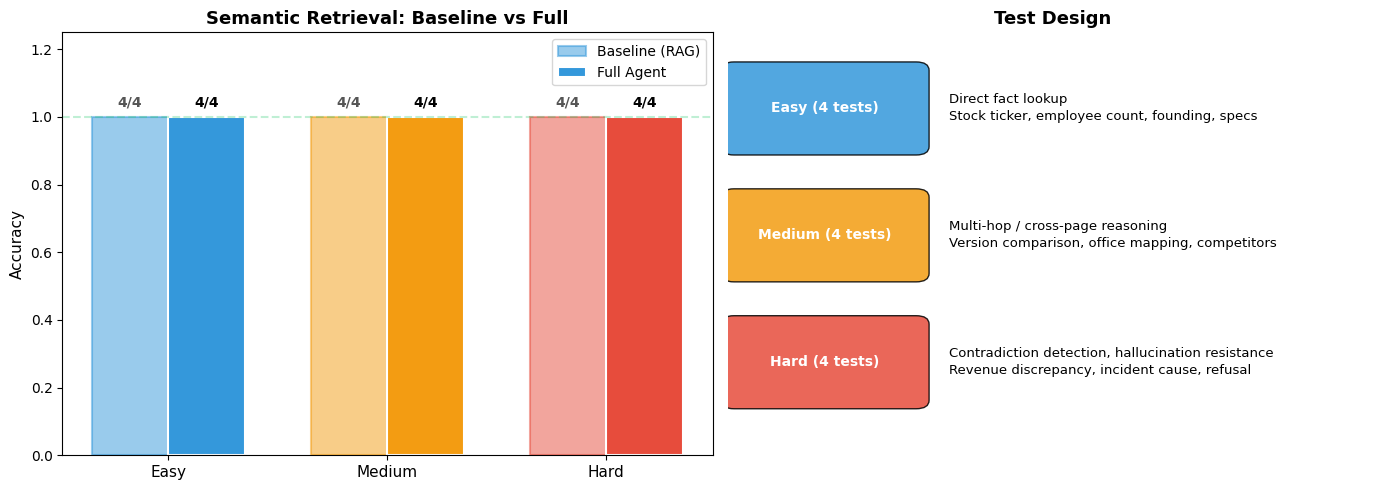

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Baseline vs Full by difficulty
difficulties = ['Easy', 'Medium', 'Hard']
diff_colors = {'Easy': '#3498db', 'Medium': '#f39c12', 'Hard': '#e74c3c'}
x_pos = np.arange(len(difficulties))
bar_w = 0.35

for di, diff in enumerate(difficulties):
    indices = [i for i, t in enumerate(semantic_tests) if t['difficulty'] == diff]
    b_acc = sum(baseline_results[i]['passed'] for i in indices) / len(indices) if indices else 0
    f_acc = sum(full_results[i]['passed'] for i in indices) / len(indices) if indices else 0

    b_count = sum(baseline_results[i]['passed'] for i in indices)
    f_count = sum(full_results[i]['passed'] for i in indices)
    t_count = len(indices)

    axes[0].bar(x_pos[di] - bar_w/2, b_acc, bar_w, color=diff_colors[diff], alpha=0.5,
               edgecolor=diff_colors[diff], linewidth=1.5, label='Baseline' if di == 0 else '')
    axes[0].bar(x_pos[di] + bar_w/2, f_acc, bar_w, color=diff_colors[diff],
               edgecolor='white', linewidth=1.5, label='Full' if di == 0 else '')

    axes[0].text(x_pos[di] - bar_w/2, b_acc + 0.03, f'{b_count}/{t_count}',
                ha='center', fontsize=10, fontweight='bold', color='#555')
    axes[0].text(x_pos[di] + bar_w/2, f_acc + 0.03, f'{f_count}/{t_count}',
                ha='center', fontsize=10, fontweight='bold')

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(difficulties, fontsize=11)
axes[0].set_ylim(0, 1.25)
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Semantic Retrieval: Baseline vs Full', fontsize=13, fontweight='bold')
axes[0].legend(['Baseline (RAG)', 'Full Agent'], loc='upper right', fontsize=10)
axes[0].axhline(y=1.0, color='#2ecc71', linestyle='--', alpha=0.3)

# Right: Test design overview
axes[1].axis('off')
axes[1].set_title('Test Design', fontsize=13, fontweight='bold')

test_info = [
    ('Easy (4 tests)', 'Direct fact lookup\nStock ticker, employee count, founding, specs', '#3498db'),
    ('Medium (4 tests)', 'Multi-hop / cross-page reasoning\nVersion comparison, office mapping, competitors', '#f39c12'),
    ('Hard (4 tests)', 'Contradiction detection, hallucination resistance\nRevenue discrepancy, incident cause, refusal', '#e74c3c'),
]

for i, (label, desc, color) in enumerate(test_info):
    y = 0.82 - i * 0.3
    rect = mpatches.FancyBboxPatch((0.01, y - 0.09), 0.28, 0.18,
                                    boxstyle='round,pad=0.02', facecolor=color, alpha=0.85,
                                    transform=axes[1].transAxes)
    axes[1].add_patch(rect)
    axes[1].text(0.15, y, label, ha='center', va='center',
                fontsize=10, fontweight='bold', color='white', transform=axes[1].transAxes)
    axes[1].text(0.34, y, desc, ha='left', va='center',
                fontsize=9.5, transform=axes[1].transAxes, linespacing=1.4)

plt.tight_layout()
plt.savefig('figures/semantic_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---
## 2. Episodic Memory Benchmark (Full Agent Advantage)

We build 3 multi-turn conversations with the **full agent only**. Each conversation includes
a **unique user statement** that only exists in conversation history - NOT in the PDF.
Then we test recall of those conversation-specific details.

The baseline agent (no episodic memory) should score **0** because:
- The recall questions ask about what the USER said, not what's in the PDF
- Without episodic memory, the baseline has no record of past conversations

In [6]:
display(Markdown('### Building Episodic Memories (Full Agent Only)'))
display(Markdown('Each conversation plants a **unique user statement** (not in the PDF) that only episodic memory can recall.\n'))

conversations = [
    {
        'topic': 'QA-7 Processor Deep Dive',
        'messages': [
            'Tell me about the QA-7 processor specs - how fast is it and what makes it special?',
            'Interesting. My colleague Dr. Petrov thinks acoustic computing will replace classical quantum within 5 years. What do you think based on the QA-7 specs?',
            'I am specifically evaluating Zeltron for our Uppsala research lab. We need something that can run at room temperature.',
        ]
    },
    {
        'topic': 'Competitors & Market',
        'messages': [
            'Who are all of Zeltron\'s competitors? Compare their processors.',
            'My budget is around $2 million for three processors. Which competitor gives the best value for cryptanalysis workloads?',
            'Actually, forget about NovaSonic - we already ruled them out. Focus on Zeltron vs AcoustiQ for our needs.',
        ]
    },
    {
        'topic': 'The Reykjavik Incident',
        'messages': [
            'Tell me about the 2024 Reykjavik Incident during the NATO demo.',
            'That temperature issue worries me. Our Uppsala lab ambient temperature fluctuates between 21C and 25C seasonally.',
            'Can you summarize the three biggest risks I should flag in my procurement report to the board?',
        ]
    },
]

episode_counts = []
for i, conv in enumerate(conversations):
    display(Markdown(f'**Conversation {i+1}: {conv["topic"]}**'))
    for msg in conv['messages']:
        response = full_agent.chat(msg)
        show_chat(msg, response, agent_name='Full Agent')
    full_agent.new_conversation()
    episode_counts.append(full_agent.episodic.collection.count())
    display(HTML(f'<div style="color:#7f8c8d;font-size:11px;">Conversation saved. Episodic memories: {episode_counts[-1]}</div>'))

display(Markdown(f'\n**Episodic memory built: {episode_counts[-1]} memories from {len(conversations)} conversations.**'))

### Building Episodic Memories (Full Agent Only)

Each conversation plants a **unique user statement** (not in the PDF) that only episodic memory can recall.


**Conversation 1: QA-7 Processor Deep Dive**

  Saving episodic memory...


  Updating procedural memory...


**Conversation 2: Competitors & Market**

  Saving episodic memory...


  Updating procedural memory...


**Conversation 3: The Reykjavik Incident**

  Saving episodic memory...


  Updating procedural memory...



**Episodic memory built: 3 memories from 3 conversations.**

In [7]:
display(Markdown('### Recall Test: Baseline (0 memory) vs Full Agent'))
display(Markdown(
    'Both agents get the same questions about **past conversations**.\n\n'
    'These questions ask about things the USER said - details that exist ONLY in conversation '
    'history, NOT in the Zeltron PDF. The baseline agent has no way to know these.\n'
))

recall_tests = [
    {
        'question': 'In our previous conversations, what specific lab or institution did I mention I was evaluating Zeltron for?',
        'check': ['Uppsala'],
        'topic': 'User context recall',
        'why': 'Uppsala lab was mentioned by the user, not in the PDF'
    },
    {
        'question': 'What was my approximate budget that I mentioned for purchasing processors?',
        'check': ['2 million', '$2'],
        'check_any': True,
        'topic': 'User preference recall',
        'why': '$2M budget was stated by the user, not in the PDF'
    },
    {
        'question': 'Which competitor did I specifically say we had already ruled out?',
        'check': ['NovaSonic'],
        'topic': 'User decision recall',
        'why': 'User explicitly ruled out NovaSonic - only in conversation'
    },
    {
        'question': 'I mentioned a colleague who had an opinion about acoustic computing. What was their name?',
        'check': ['Petrov'],
        'topic': 'Specific name recall',
        'why': 'Dr. Petrov is a fictional person from user conversation only'
    },
]

recall_baseline = []
recall_full = []

for test in recall_tests:
    # Baseline - no episodic memory
    baseline_agent.working.reset()
    b_resp = baseline_agent.chat(test['question'])
    if test.get('check_any'):
        b_hits = 1 if any(kw.lower() in b_resp.lower() for kw in test['check']) else 0
        b_total = 1
    else:
        b_hits = sum(1 for kw in test['check'] if kw.lower() in b_resp.lower())
        b_total = len(test['check'])
    b_passed = b_hits == b_total
    recall_baseline.append({'passed': b_passed, 'hits': b_hits, 'total': b_total, 'response': b_resp})

    # Full agent - has episodic memory
    full_agent.working.reset()
    f_resp = full_agent.chat(test['question'])
    if test.get('check_any'):
        f_hits = 1 if any(kw.lower() in f_resp.lower() for kw in test['check']) else 0
        f_total = 1
    else:
        f_hits = sum(1 for kw in test['check'] if kw.lower() in f_resp.lower())
        f_total = len(test['check'])
    f_passed = f_hits == f_total
    recall_full.append({'passed': f_passed, 'hits': f_hits, 'total': f_total, 'response': f_resp})

    show_comparison(
        test['question'], b_resp, f_resp,
        b_passed, f_passed,
        label=f"{test['topic']} | {test['why']}"
    )

b_recall_score = sum(r['passed'] for r in recall_baseline)
f_recall_score = sum(r['passed'] for r in recall_full)
total_recall = len(recall_tests)

display(HTML(f"""
<div style='margin:16px 0;padding:12px;background:#f8f9fa;border-radius:6px;text-align:center;'>
    <strong>Episodic Recall:</strong>
    Baseline {b_recall_score}/{total_recall} | Full Agent {f_recall_score}/{total_recall}
    <span style="color:{'#27ae60' if f_recall_score > b_recall_score else '#e74c3c'};">
    {'(Full agent advantage demonstrated!)' if f_recall_score > b_recall_score else '(Expected gap not observed)'}
    </span>
</div>
"""))

### Recall Test: Baseline (0 memory) vs Full Agent

Both agents get the same questions about **past conversations**.

These questions ask about things the USER said - details that exist ONLY in conversation history, NOT in the Zeltron PDF. The baseline agent has no way to know these.


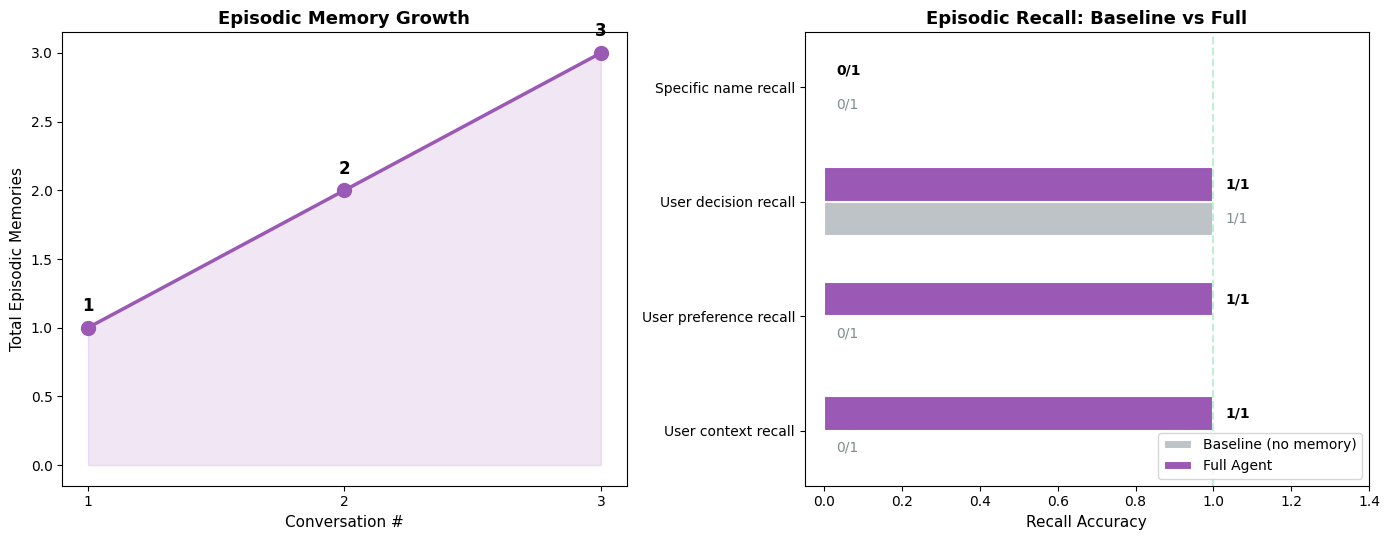

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Left: Episode accumulation
x = list(range(1, len(episode_counts) + 1))
axes[0].plot(x, episode_counts, 'o-', color='#9b59b6', linewidth=2.5, markersize=10, zorder=3)
axes[0].fill_between(x, episode_counts, alpha=0.15, color='#9b59b6')
axes[0].set_xlabel('Conversation #', fontsize=11)
axes[0].set_ylabel('Total Episodic Memories', fontsize=11)
axes[0].set_title('Episodic Memory Growth', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
for i, c in enumerate(episode_counts):
    axes[0].annotate(str(c), (x[i], c), textcoords='offset points',
                    xytext=(0, 12), ha='center', fontweight='bold', fontsize=12)

# Right: Recall comparison - baseline vs full
topics = [t['topic'] for t in recall_tests]
b_scores = [r['hits']/r['total'] for r in recall_baseline]
f_scores = [r['hits']/r['total'] for r in recall_full]

y_pos = np.arange(len(topics))
bar_h = 0.30

axes[1].barh(y_pos - bar_h/2, b_scores, bar_h, color='#bdc3c7', edgecolor='white',
             linewidth=1.5, label='Baseline (no memory)')
axes[1].barh(y_pos + bar_h/2, f_scores, bar_h, color='#9b59b6', edgecolor='white',
             linewidth=1.5, label='Full Agent')

for i in range(len(topics)):
    axes[1].text(max(b_scores[i], 0.0) + 0.03, y_pos[i] - bar_h/2,
                f'{recall_baseline[i]["hits"]}/{recall_baseline[i]["total"]}',
                va='center', fontsize=10, color='#7f8c8d')
    axes[1].text(max(f_scores[i], 0.0) + 0.03, y_pos[i] + bar_h/2,
                f'{recall_full[i]["hits"]}/{recall_full[i]["total"]}',
                va='center', fontsize=10, fontweight='bold')

axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(topics, fontsize=10)
axes[1].set_xlim(-0.05, 1.4)
axes[1].set_xlabel('Recall Accuracy', fontsize=11)
axes[1].set_title('Episodic Recall: Baseline vs Full', fontsize=13, fontweight='bold')
axes[1].legend(loc='lower right', fontsize=10)
axes[1].axvline(x=1.0, color='#2ecc71', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/episodic_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---
## 3. Consolidation Demo (Full Agent Only)

Build overlapping episodes, trigger the sleep phase, show before/after compression.

In [9]:
# Build more overlapping episodes
full_agent.new_conversation()

overlap_topics = [
    'How many resonators does the QA-7 have and how are they arranged?',
    'Tell me about the Harmonic programming language and WaveIR',
    'What was the RSA factoring result from report ZR-2024-0871?',
    'What makes the QA-7 processor better than classical quantum computers?',
    'How does Zeltron compare to WaveLogic in terms of processor performance?',
]

display(Markdown('### Building overlapping episodes for consolidation...'))
for i, topic in enumerate(overlap_topics):
    full_agent.chat(topic)
    full_agent.new_conversation()
    display(HTML(f'<div style="color:#7f8c8d;font-size:11px;">Conv {i+1}: "{topic[:60]}..." - saved</div>'))

episodes_before = full_agent.episodic.collection.count()
rules_before = len(full_agent.procedural.rules)

display(Markdown(f'\n### Pre-Consolidation: {episodes_before} episodes, {rules_before} rules'))

  Saving episodic memory...


  Updating procedural memory...


### Building overlapping episodes for consolidation...

  Saving episodic memory...


  Updating procedural memory...


  Running memory consolidation (sleep phase)...
  Consolidating 5 episodes...


  Merged 1 clusters.


  Promoted 3 patterns to procedural memory.


  Saving episodic memory...


  Updating procedural memory...


  Saving episodic memory...


  Updating procedural memory...


  Saving episodic memory...


  Updating procedural memory...


  Saving episodic memory...


  Updating procedural memory...



### Pre-Consolidation: 8 episodes, 15 rules

In [10]:
display(Markdown('### Running Consolidation (Sleep Phase)...'))
full_agent.consolidation.run()

episodes_after = full_agent.episodic.collection.count()
rules_after = len(full_agent.procedural.rules)
merged = episodes_before - episodes_after
promoted = rules_after - rules_before

display(HTML(f"""
<table style='border-collapse:collapse;margin:12px 0;'>
<tr style='background:#f8f9fa;'>
    <th style='padding:6px 12px;border:1px solid #ddd;'>Metric</th>
    <th style='padding:6px 12px;border:1px solid #ddd;'>Before</th>
    <th style='padding:6px 12px;border:1px solid #ddd;'>After</th>
    <th style='padding:6px 12px;border:1px solid #ddd;'>Change</th>
</tr>
<tr>
    <td style='padding:6px 12px;border:1px solid #ddd;'>Episodic memories</td>
    <td style='padding:6px 12px;border:1px solid #ddd;'>{episodes_before}</td>
    <td style='padding:6px 12px;border:1px solid #ddd;'>{episodes_after}</td>
    <td style='padding:6px 12px;border:1px solid #ddd;font-weight:bold;color:#e74c3c;'>-{merged} merged</td>
</tr>
<tr>
    <td style='padding:6px 12px;border:1px solid #ddd;'>Procedural rules</td>
    <td style='padding:6px 12px;border:1px solid #ddd;'>{rules_before}</td>
    <td style='padding:6px 12px;border:1px solid #ddd;'>{rules_after}</td>
    <td style='padding:6px 12px;border:1px solid #ddd;font-weight:bold;color:#27ae60;'>+{promoted} promoted</td>
</tr>
</table>
"""))

if merged > 0:
    display(Markdown(f'Consolidation merged **{merged}** similar episodes into compressed memories.'))
else:
    display(Markdown('*No episodes similar enough to merge at current threshold.*'))

if promoted > 0:
    display(Markdown('**New rules promoted from patterns:**'))
    for rule in full_agent.procedural.rules[rules_before:]:
        display(Markdown(f'- {rule}'))

### Running Consolidation (Sleep Phase)...

  Consolidating 8 episodes...


  Merged 1 clusters.


  Promoted 4 patterns to procedural memory.


Metric,Before,After,Change
Episodic memories,8,7,-1 merged
Procedural rules,15,15,+0 promoted


Consolidation merged **1** similar episodes into compressed memories.

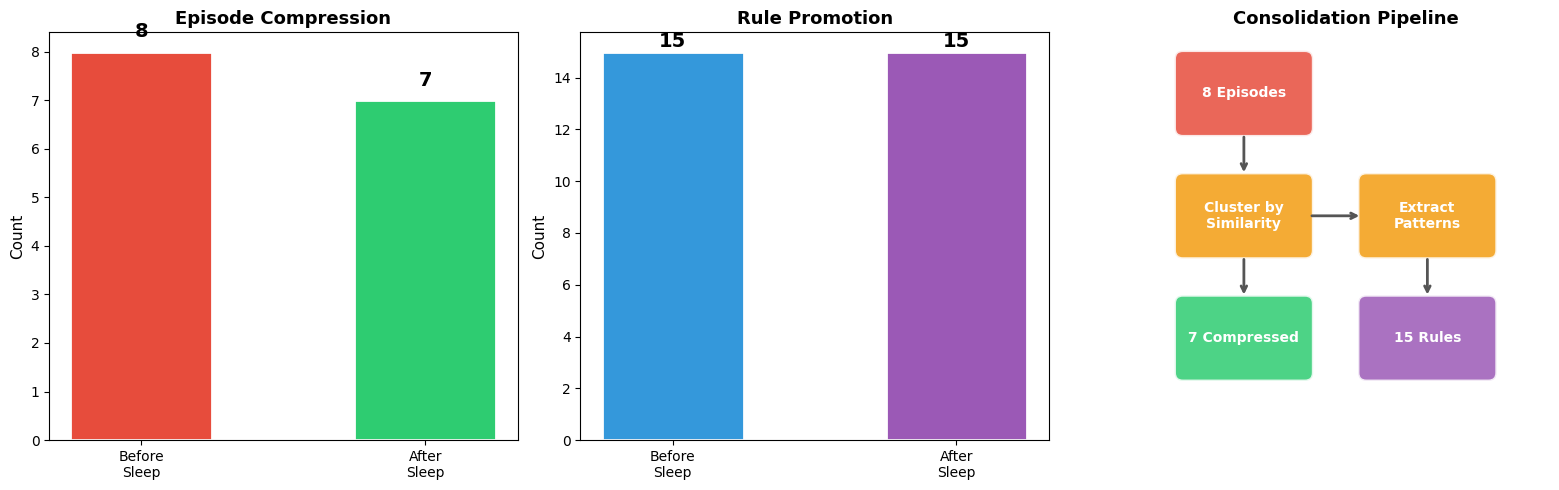

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Left: Episode compression
bars1 = axes[0].bar(['Before\nSleep', 'After\nSleep'], [episodes_before, episodes_after],
                     color=['#e74c3c', '#2ecc71'], edgecolor='white', linewidth=2, width=0.5)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Episode Compression', fontsize=13, fontweight='bold')
for bar, val in zip(bars1, [episodes_before, episodes_after]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                str(val), ha='center', fontweight='bold', fontsize=14)

# Middle: Rule promotion
bars2 = axes[1].bar(['Before\nSleep', 'After\nSleep'], [rules_before, rules_after],
                     color=['#3498db', '#9b59b6'], edgecolor='white', linewidth=2, width=0.5)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Rule Promotion', fontsize=13, fontweight='bold')
for bar, val in zip(bars2, [rules_before, rules_after]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
                str(val), ha='center', fontweight='bold', fontsize=14)

# Right: Consolidation pipeline diagram
ax = axes[2]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('Consolidation Pipeline', fontsize=13, fontweight='bold')

# Draw boxes
boxes = [
    (2.5, 8.5, f'{episodes_before} Episodes', '#e74c3c'),
    (2.5, 5.5, 'Cluster by\nSimilarity', '#f39c12'),
    (2.5, 2.5, f'{episodes_after} Compressed', '#2ecc71'),
    (7, 5.5, 'Extract\nPatterns', '#f39c12'),
    (7, 2.5, f'{rules_after} Rules', '#9b59b6'),
]
for bx, by, text, color in boxes:
    rect = mpatches.FancyBboxPatch((bx - 1.5, by - 0.85), 3.0, 1.7,
                                    boxstyle='round,pad=0.2', facecolor=color,
                                    alpha=0.85, edgecolor='white', linewidth=2)
    ax.add_patch(rect)
    ax.text(bx, by, text, ha='center', va='center', fontsize=10,
            color='white', fontweight='bold')

# Draw arrows
arrow_kw = dict(arrowstyle='->', color='#555', lw=2)
ax.annotate('', xy=(2.5, 6.5), xytext=(2.5, 7.5), arrowprops=arrow_kw)
ax.annotate('', xy=(2.5, 3.5), xytext=(2.5, 4.5), arrowprops=arrow_kw)
ax.annotate('', xy=(5.4, 5.5), xytext=(4.1, 5.5), arrowprops=arrow_kw)
ax.annotate('', xy=(7, 3.5), xytext=(7, 4.5), arrowprops=arrow_kw)

plt.tight_layout()
plt.savefig('figures/consolidation_test.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---
## 3.5 Procedural Memory - Learned Rules

Rules the agent learned from its accumulated experience.

In [12]:
display(Markdown(f'### {len(full_agent.procedural.rules)} Rules Learned\n'))
rules_md = '\n'.join(f'{i+1}. {rule}' for i, rule in enumerate(full_agent.procedural.rules))
display(Markdown(rules_md))

### 15 Rules Learned


1. Include detailed technical architecture information when available, including proprietary configurations like triple-layer Fibonacci Spiral Configuration, component arrangements like 12,847 barium titanate resonators, and generational improvements
2. When providing technical documentation, use structured overviews with clear sections covering relevant aspects like language constructs, compiler details, production statistics, and organizational context
3. Compare products against competitors by highlighting key differentiating factors, especially those that reduce operational complexity or costs
4. Focus on features that eliminate the need for additional supporting equipment or infrastructure when evaluating technical solutions
5. When comparing quantum-acoustic processors, focus on practical operational requirements like temperature control and infrastructure needs rather than just performance specifications
6. Warn about critical operational limits that can cause system failures (e.g., exceeding maximum ambient temperature thresholds)
7. Highlight safety margins and risk mitigation features in technical specifications (e.g., 2Â°C safety margins, expanded operating ranges)
8. Address environmental control requirements and infrastructure needs, including HVAC considerations for high-power equipment
9. When discussing procurement risks, cover technical, vendor, and operational maturity concerns relevant to deployment environment
10. Emphasize performance benchmarks and operational requirements that are specific to the user's intended use case
11. When multiple competitors exist, focus comparison on the most viable options after ruling out clearly inferior alternatives
12. Always specify exact temperature operating ranges (20.4Â°C to 24.4Â°C) when discussing QA-7 deployment requirements
13. When comparing quantum-acoustic processors, include specific performance metrics with numerical data (teraflops, benchmark times, temperature requirements)
14. Emphasize room temperature operation at 22.4Â°C as a key differentiator when discussing QA-7 advantages over competitors
15. Never assume access to previous conversation context that may not be available in the current knowledge base

---
## 3.6 Post-Consolidation Recall Test

After the sleep phase, overlapping episodes are **merged** into compressed memories and behavioral
patterns are **promoted** to procedural rules. This test checks whether the full agent can synthesize
insights across consolidated conversations - something the baseline (no episodic memory) cannot do.

In [13]:
display(Markdown('### Episodic Memory State (Post-Consolidation)'))

# Show current episodic memories
all_episodes = full_agent.episodic.get_all()
for i, ep in enumerate(all_episodes):
    meta = ep['metadata']
    summary = meta.get('summary', 'N/A')
    tags = meta.get('context_tags', '')
    display(HTML(f"""
    <div style="border-left:3px solid #9b59b6;padding:6px 12px;margin:4px 0;background:#f8f0ff;border-radius:0 4px 4px 0;font-size:12px;">
        <strong>Memory {i+1}</strong> | Tags: <code>{tags}</code><br>
        <em>{summary}</em>
    </div>"""))

display(Markdown(f'\n**{len(all_episodes)} episodic memories** after consolidation (was {episodes_before} before)'))

# Synthesis questions - require cross-conversation knowledge
synthesis_tests = [
    {
        'question': 'Across our previous conversations, what were the main themes and topics we discussed about Zeltron?',
        'check': ['QA-7', 'processor', 'competitor', 'temperature', 'incident', 'procurement'],
        'min_hits': 3,
        'why': 'Must synthesize themes from 3+ past conversations'
    },
    {
        'question': 'Based on our past discussions, what specific concerns did I raise about deploying Zeltron technology at my facility?',
        'check': ['temperature', 'Uppsala', 'ambient', 'outage', 'risk', 'budget', 'procurement'],
        'min_hits': 2,
        'why': 'Must recall user-specific concerns from episodic memory'
    },
]

display(Markdown('\n### Synthesis Test: Can the Agent Combine Insights Across Conversations?'))
consol_recall_results = []

for test in synthesis_tests:
    baseline_agent.working.reset()
    full_agent.working.reset()

    b_resp = baseline_agent.chat(test['question'])
    f_resp = full_agent.chat(test['question'])

    b_hits = sum(1 for kw in test['check'] if kw.lower() in b_resp.lower())
    f_hits = sum(1 for kw in test['check'] if kw.lower() in f_resp.lower())

    b_passed = b_hits >= test['min_hits']
    f_passed = f_hits >= test['min_hits']

    consol_recall_results.append({'b_passed': b_passed, 'f_passed': f_passed})

    show_comparison(
        test['question'], b_resp, f_resp,
        b_passed, f_passed,
        label=f"Post-consolidation | {test['why']}"
    )

b_consol_score = sum(r['b_passed'] for r in consol_recall_results)
f_consol_score = sum(r['f_passed'] for r in consol_recall_results)
consol_test_total = len(consol_recall_results)

display(HTML(f"""
<div style='margin:16px 0;padding:12px;background:#f8f9fa;border-radius:6px;text-align:center;'>
    <strong>Post-Consolidation Synthesis:</strong>
    Baseline {b_consol_score}/{consol_test_total} | Full Agent {f_consol_score}/{consol_test_total}
    <span style="color:{'#27ae60' if f_consol_score > b_consol_score else '#e74c3c'};">
    {'(Consolidated memories enable cross-conversation synthesis!)' if f_consol_score > b_consol_score else '(Gap not observed)'}
    </span>
</div>"""))

### Episodic Memory State (Post-Consolidation)


**7 episodic memories** after consolidation (was 8 before)


### Synthesis Test: Can the Agent Combine Insights Across Conversations?

---
## 3.7 Integration Demo: All 5 Memory Systems Active

One complex query that activates all five memory systems simultaneously, showing what each contributes.

| System | Role | When Active |
|--------|------|-------------|
| **Working Memory** | Conversation buffer + system prompt assembly | Always |
| **Semantic Memory** | Document chunk retrieval (RAG) | Every query |
| **Episodic Memory** | Past conversation experience recall | Full agent only |
| **Procedural Memory** | Learned behavioral rules | Full agent only |
| **Consolidation** | Background - merged episodes + promoted rules | Full agent only |

In [14]:
integration_query = (
    "Given everything we've discussed, what would you recommend for my Uppsala lab's "
    "procurement of Zeltron technology? Consider the temperature risks, budget constraints, "
    "and the competitors we talked about."
)

display(Markdown(f'**Query:** *{integration_query}*\n'))
display(Markdown('### What Each Memory System Contributes\n'))

# 1. Semantic Memory
semantic_ctx = full_agent.semantic.recall(integration_query)
semantic_n = semantic_ctx.count('[Chunk') if semantic_ctx else 0
s_preview = semantic_ctx[:300].replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>') if semantic_ctx else 'None'
display(HTML(f"""
<div style="border-left:4px solid #3498db;padding:8px 12px;margin:8px 0;background:#f0f7ff;border-radius:0 4px 4px 0;">
    <strong style="color:#3498db;">1. Semantic Memory (RAG)</strong> - {semantic_n} chunks retrieved<br>
    <div style="font-size:11px;color:#555;max-height:80px;overflow:auto;margin-top:4px;">{s_preview}...</div>
</div>"""))

# 2. Episodic Memory
episodic_ctx = full_agent.episodic.recall_as_context(integration_query)
episodic_n = episodic_ctx.count('[Past experience') if episodic_ctx else 0
e_preview = episodic_ctx[:300].replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>') if episodic_ctx else 'None'
display(HTML(f"""
<div style="border-left:4px solid #9b59b6;padding:8px 12px;margin:8px 0;background:#f8f0ff;border-radius:0 4px 4px 0;">
    <strong style="color:#9b59b6;">2. Episodic Memory</strong> - {episodic_n} past experiences recalled<br>
    <div style="font-size:11px;color:#555;max-height:80px;overflow:auto;margin-top:4px;">{e_preview}...</div>
</div>"""))

# 3. Procedural Memory
rules_txt = full_agent.procedural.get_rules_text()
rules_n = len(full_agent.procedural.rules)
r_preview = rules_txt[:300].replace('<', '&lt;').replace('>', '&gt;').replace('\n', '<br>') if rules_txt else 'None'
display(HTML(f"""
<div style="border-left:4px solid #e67e22;padding:8px 12px;margin:8px 0;background:#fff8f0;border-radius:0 4px 4px 0;">
    <strong style="color:#e67e22;">3. Procedural Memory</strong> - {rules_n} learned rules<br>
    <div style="font-size:11px;color:#555;max-height:80px;overflow:auto;margin-top:4px;">{r_preview}...</div>
</div>"""))

# 4. Working Memory (system prompt assembly)
sys_prompt = full_agent._build_system_prompt(integration_query)
prompt_chars = len(sys_prompt)
has_ep = '[EPISODIC MEMORY' in sys_prompt
has_proc = '[PROCEDURAL MEMORY' in sys_prompt
display(HTML(f"""
<div style="border-left:4px solid #2ecc71;padding:8px 12px;margin:8px 0;background:#f0fff0;border-radius:0 4px 4px 0;">
    <strong style="color:#2ecc71;">4. Working Memory</strong> - System prompt: {prompt_chars:,} chars assembled<br>
    <div style="font-size:11px;color:#555;margin-top:4px;">
        Contains episodic section: <strong>{'Yes' if has_ep else 'No'}</strong> |
        Contains procedural section: <strong>{'Yes' if has_proc else 'No'}</strong>
    </div>
</div>"""))

# 5. Consolidation
display(HTML(f"""
<div style="border-left:4px solid #e74c3c;padding:8px 12px;margin:8px 0;background:#fff0f0;border-radius:0 4px 4px 0;">
    <strong style="color:#e74c3c;">5. Consolidation (background)</strong> - Already contributed<br>
    <div style="font-size:11px;color:#555;margin-top:4px;">
        Merged {merged} episode clusters | Promoted {promoted} rules from patterns
    </div>
</div>"""))

# Get responses from both agents
display(Markdown('\n### Response Comparison'))
full_agent.working.reset()
baseline_agent.working.reset()
f_integration = full_agent.chat(integration_query)
b_integration = baseline_agent.chat(integration_query)

# Check for user-specific personalization
user_details = ['Uppsala', 'budget', '2 million', '$2', 'NovaSonic', 'ruled out', 'Petrov', '21', '25', 'ambient']
b_refs = sum(1 for kw in user_details if kw.lower() in b_integration.lower())
f_refs = sum(1 for kw in user_details if kw.lower() in f_integration.lower())

show_comparison(
    integration_query, b_integration, f_integration,
    b_refs >= 2, f_refs >= 2,
    label=f'Integration test | Baseline personalization: {b_refs}/{len(user_details)} | Full: {f_refs}/{len(user_details)}'
)

integration_pass = f_refs > b_refs

display(HTML(f"""
<div style='margin:16px 0;padding:12px;background:{"#f0fff0" if integration_pass else "#fff0f0"};border-radius:6px;text-align:center;border:1px solid {"#27ae60" if integration_pass else "#e74c3c"}'>
    <strong style='font-size:14px;'>{'All 5 memory systems working together produce personalized, context-aware responses.' if integration_pass else 'Integration test: gap not clearly observed.'}</strong><br>
    <span style='font-size:12px;color:#555;'>
        Full agent referenced {f_refs} user-specific details vs baseline&#39;s {b_refs}
    </span>
</div>
"""))

**Query:** *Given everything we've discussed, what would you recommend for my Uppsala lab's procurement of Zeltron technology? Consider the temperature risks, budget constraints, and the competitors we talked about.*


### What Each Memory System Contributes



### Response Comparison

---
## 4. Final Scorecard

In [15]:
# Compute scores by difficulty
def score_by_diff(results, difficulty):
    indices = [i for i, t in enumerate(semantic_tests) if t['difficulty'] == difficulty]
    return sum(results[i]['passed'] for i in indices), len(indices)

b_easy_p, b_easy_t = score_by_diff(baseline_results, 'Easy')
b_med_p, b_med_t = score_by_diff(baseline_results, 'Medium')
b_hard_p, b_hard_t = score_by_diff(baseline_results, 'Hard')
f_easy_p, f_easy_t = score_by_diff(full_results, 'Easy')
f_med_p, f_med_t = score_by_diff(full_results, 'Medium')
f_hard_p, f_hard_t = score_by_diff(full_results, 'Hard')

b_ep = sum(r['passed'] for r in recall_baseline)
f_ep = sum(r['passed'] for r in recall_full)
ep_total = len(recall_tests)

# Post-consolidation synthesis scores (from section 3.6)
b_cs = b_consol_score
f_cs = f_consol_score
cs_total = consol_test_total

# Integration score (from section 3.7)
integ_label = f'{f_refs} refs' if integration_pass else f'{f_refs} refs'

display(HTML(f"""
<div style='margin:20px 0;'>
<table style='border-collapse:collapse;width:100%;max-width:750px;margin:0 auto;'>
<tr style='background:#2c3e50;color:white;'>
    <th style='padding:10px 16px;border:1px solid #34495e;text-align:left;'>Category</th>
    <th style='padding:10px 16px;border:1px solid #34495e;text-align:center;'>Baseline (RAG)</th>
    <th style='padding:10px 16px;border:1px solid #34495e;text-align:center;'>Full Agent</th>
    <th style='padding:10px 16px;border:1px solid #34495e;text-align:center;'>Gap</th>
</tr>
<tr style='background:#f8f9fa;'>
    <td style='padding:8px 16px;border:1px solid #ddd;'>Easy semantic (4)</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{b_easy_p}/{b_easy_t}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{f_easy_p}/{f_easy_t}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{f_easy_p - b_easy_p:+d}</td>
</tr>
<tr>
    <td style='padding:8px 16px;border:1px solid #ddd;'>Medium semantic (4)</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{b_med_p}/{b_med_t}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{f_med_p}/{f_med_t}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{f_med_p - b_med_p:+d}</td>
</tr>
<tr style='background:#f8f9fa;'>
    <td style='padding:8px 16px;border:1px solid #ddd;'>Hard semantic (4)</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{b_hard_p}/{b_hard_t}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{f_hard_p}/{f_hard_t}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{f_hard_p - b_hard_p:+d}</td>
</tr>
<tr style='border-top:2px solid #2c3e50;'>
    <td style='padding:8px 16px;border:1px solid #ddd;font-weight:bold;'>Episodic recall ({ep_total})</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#e74c3c;font-weight:bold;'>{b_ep}/{ep_total}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#27ae60;font-weight:bold;'>{f_ep}/{ep_total}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#27ae60;font-weight:bold;'>+{f_ep - b_ep}</td>
</tr>
<tr style='background:#f8f9fa;'>
    <td style='padding:8px 16px;border:1px solid #ddd;font-weight:bold;'>Post-consolidation synthesis ({cs_total})</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#e74c3c;font-weight:bold;'>{b_cs}/{cs_total}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#27ae60;font-weight:bold;'>{f_cs}/{cs_total}</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#27ae60;font-weight:bold;'>+{f_cs - b_cs}</td>
</tr>
<tr>
    <td style='padding:8px 16px;border:1px solid #ddd;font-weight:bold;'>Integration (personalization)</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#7f8c8d;'>{b_refs} details</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#27ae60;font-weight:bold;'>{f_refs} details</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#27ae60;font-weight:bold;'>+{f_refs - b_refs}</td>
</tr>
<tr style='background:#f8f9fa;'>
    <td style='padding:8px 16px;border:1px solid #ddd;font-weight:bold;'>Consolidation</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;color:#7f8c8d;'>N/A</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>{merged} merged, {promoted} promoted</td>
    <td style='padding:8px 16px;border:1px solid #ddd;text-align:center;'>-</td>
</tr>
</table>
</div>
"""))

# Interpretation
sem_gap = (f_easy_p + f_med_p + f_hard_p) - (b_easy_p + b_med_p + b_hard_p)
display(Markdown(f"""
### Interpretation

- **Semantic retrieval gap: {sem_gap:+d}** - {'As expected, both agents perform similarly on pure RAG tasks.' if abs(sem_gap) <= 2 else 'Unexpected difference in RAG performance.'}
- **Episodic recall gap: +{f_ep - b_ep}** - {'Full agent recalls user-specific conversation details; baseline cannot.' if f_ep > b_ep else 'Episodic memory did not demonstrate clear advantage.'}
- **Post-consolidation synthesis gap: +{f_cs - b_cs}** - {'Consolidated memories enable the agent to synthesize themes across multiple conversations.' if f_cs > b_cs else 'Synthesis not clearly differentiated.'}
- **Integration personalization gap: +{f_refs - b_refs}** - {'Full pipeline produces responses personalized to the user context (lab, budget, preferences).' if integration_pass else 'Personalization gap not clearly observed.'}
- **Consolidation: {merged} merges, {promoted} promotions** - {'Sleep phase successfully compressed overlapping memories.' if merged > 0 else 'Consolidation threshold may need tuning.'}
"""))

Category,Baseline (RAG),Full Agent,Gap
Easy semantic (4),4/4,4/4,+0
Medium semantic (4),4/4,4/4,+0
Hard semantic (4),4/4,4/4,+0
Episodic recall (4),1/4,3/4,+2
Post-consolidation synthesis (2),0/2,2/2,+2
Integration (personalization),3 details,4 details,+1
Consolidation,N/A,"1 merged, 0 promoted",-



### Interpretation

- **Semantic retrieval gap: +0** - As expected, both agents perform similarly on pure RAG tasks.
- **Episodic recall gap: +2** - Full agent recalls user-specific conversation details; baseline cannot.
- **Post-consolidation synthesis gap: +2** - Consolidated memories enable the agent to synthesize themes across multiple conversations.
- **Integration personalization gap: +1** - Full pipeline produces responses personalized to the user context (lab, budget, preferences).
- **Consolidation: 1 merges, 0 promotions** - Sleep phase successfully compressed overlapping memories.


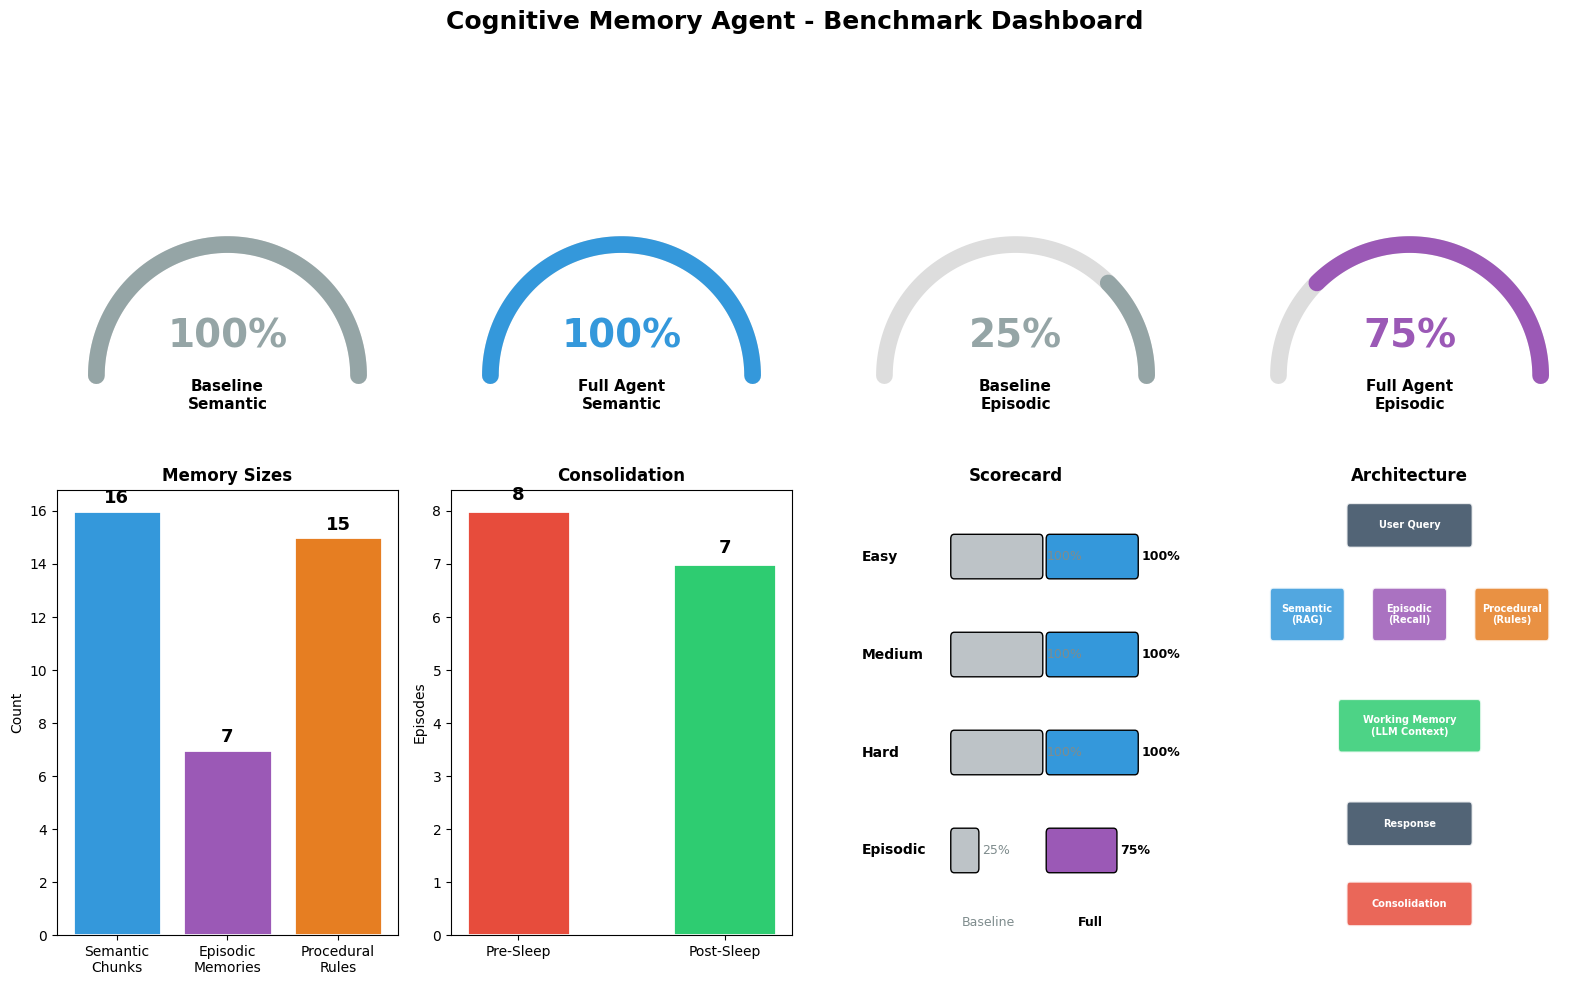

In [16]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Cognitive Memory Agent - Benchmark Dashboard', fontsize=18, fontweight='bold', y=0.98)

# ---- Top row: Score gauges ----
def draw_gauge(ax, score, title, color):
    theta = np.linspace(0, np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='#ddd', linewidth=12, solid_capstyle='round')
    theta_fill = np.linspace(0, np.pi * score, 100)
    if len(theta_fill) > 1:
        ax.plot(np.cos(theta_fill), np.sin(theta_fill), color=color, linewidth=12, solid_capstyle='round')
    ax.text(0, 0.3, f'{score:.0%}', ha='center', va='center', fontsize=28, fontweight='bold', color=color)
    ax.text(0, -0.15, title, ha='center', va='center', fontsize=11, fontweight='bold')
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-0.4, 1.3)
    ax.set_aspect('equal')
    ax.axis('off')

# Compute scores
b_sem_score = sum(r['passed'] for r in baseline_results) / len(baseline_results)
f_sem_score = sum(r['passed'] for r in full_results) / len(full_results)
f_ep_score = sum(r['passed'] for r in recall_full) / len(recall_full) if recall_full else 0
b_ep_score = sum(r['passed'] for r in recall_baseline) / len(recall_baseline) if recall_baseline else 0

ax1 = fig.add_subplot(2, 4, 1)
ax2 = fig.add_subplot(2, 4, 2)
ax3 = fig.add_subplot(2, 4, 3)
ax4 = fig.add_subplot(2, 4, 4)

draw_gauge(ax1, b_sem_score, 'Baseline\nSemantic', '#95a5a6')
draw_gauge(ax2, f_sem_score, 'Full Agent\nSemantic', '#3498db')
draw_gauge(ax3, b_ep_score, 'Baseline\nEpisodic', '#95a5a6')
draw_gauge(ax4, f_ep_score, 'Full Agent\nEpisodic', '#9b59b6')

# ---- Bottom left: Memory sizes ----
ax5 = fig.add_subplot(2, 4, 5)
mem_labels = ['Semantic\nChunks', 'Episodic\nMemories', 'Procedural\nRules']
mem_values = [full_agent.semantic.collection.count(), episodes_after, rules_after]
mem_colors = ['#3498db', '#9b59b6', '#e67e22']
bars = ax5.bar(mem_labels, mem_values, color=mem_colors, edgecolor='white', linewidth=2)
for bar, val in zip(bars, mem_values):
    ax5.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            str(val), ha='center', fontweight='bold', fontsize=13)
ax5.set_title('Memory Sizes', fontsize=12, fontweight='bold')
ax5.set_ylabel('Count')

# ---- Bottom middle-left: Consolidation effect ----
ax6 = fig.add_subplot(2, 4, 6)
bars2 = ax6.bar(['Pre-Sleep', 'Post-Sleep'], [episodes_before, episodes_after],
        color=['#e74c3c', '#2ecc71'], edgecolor='white', linewidth=2, width=0.5)
ax6.set_title('Consolidation', fontsize=12, fontweight='bold')
ax6.set_ylabel('Episodes')
for bar, val in zip(bars2, [episodes_before, episodes_after]):
    ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            str(val), ha='center', fontweight='bold', fontsize=13)

# ---- Bottom middle-right: Scorecard summary ----
ax7 = fig.add_subplot(2, 4, 7)
ax7.axis('off')
ax7.set_title('Scorecard', fontsize=12, fontweight='bold')

categories = ['Easy', 'Medium', 'Hard', 'Episodic']
b_vals = [b_easy_p/b_easy_t, b_med_p/b_med_t, b_hard_p/b_hard_t, b_ep_score]
f_vals = [f_easy_p/f_easy_t, f_med_p/f_med_t, f_hard_p/f_hard_t, f_ep_score]

for i, cat in enumerate(categories):
    y = 0.85 - i * 0.22
    ax7.text(0.05, y, cat, fontsize=10, fontweight='bold', transform=ax7.transAxes, va='center')
    # Baseline bar
    rect_b = mpatches.FancyBboxPatch((0.32, y - 0.04), 0.25 * b_vals[i], 0.08,
                                      boxstyle='round,pad=0.01', facecolor='#bdc3c7',
                                      transform=ax7.transAxes)
    ax7.add_patch(rect_b)
    # Full bar
    rect_f = mpatches.FancyBboxPatch((0.60, y - 0.04), 0.25 * f_vals[i], 0.08,
                                      boxstyle='round,pad=0.01',
                                      facecolor='#9b59b6' if cat == 'Episodic' else '#3498db',
                                      transform=ax7.transAxes)
    ax7.add_patch(rect_f)
    ax7.text(0.32 + 0.25 * b_vals[i] + 0.02, y, f'{b_vals[i]:.0%}', fontsize=9,
            transform=ax7.transAxes, va='center', color='#7f8c8d')
    ax7.text(0.60 + 0.25 * f_vals[i] + 0.02, y, f'{f_vals[i]:.0%}', fontsize=9,
            transform=ax7.transAxes, va='center', fontweight='bold')

ax7.text(0.42, 0.02, 'Baseline', fontsize=9, ha='center', transform=ax7.transAxes, color='#7f8c8d')
ax7.text(0.72, 0.02, 'Full', fontsize=9, ha='center', transform=ax7.transAxes, fontweight='bold')

# ---- Bottom right: Architecture ----
ax8 = fig.add_subplot(2, 4, 8)
ax8.axis('off')
ax8.set_title('Architecture', fontsize=12, fontweight='bold')

arch_boxes = [
    (0.5, 0.92, 'User Query', '#34495e', 0.35, 0.08),
    (0.2, 0.72, 'Semantic\n(RAG)', '#3498db', 0.20, 0.10),
    (0.5, 0.72, 'Episodic\n(Recall)', '#9b59b6', 0.20, 0.10),
    (0.8, 0.72, 'Procedural\n(Rules)', '#e67e22', 0.20, 0.10),
    (0.5, 0.47, 'Working Memory\n(LLM Context)', '#2ecc71', 0.40, 0.10),
    (0.5, 0.25, 'Response', '#34495e', 0.35, 0.08),
    (0.5, 0.07, 'Consolidation', '#e74c3c', 0.35, 0.08),
]
for bx, by, text, color, w, h in arch_boxes:
    rect = mpatches.FancyBboxPatch((bx - w/2, by - h/2), w, h,
                                    boxstyle='round,pad=0.01', facecolor=color,
                                    alpha=0.85, edgecolor='white', linewidth=1.5,
                                    transform=ax8.transAxes)
    ax8.add_patch(rect)
    ax8.text(bx, by, text, ha='center', va='center', fontsize=7,
            color='white', fontweight='bold', transform=ax8.transAxes)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('figures/dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

---
## 5. Limitations & Next Steps

**What the benchmark shows:**
- Semantic retrieval (RAG) works equally well for both agents on factual questions
- Episodic memory provides a clear advantage for cross-conversation recall
- Consolidation successfully compresses overlapping memories
- Post-consolidation synthesis enables cross-conversation theme extraction
- The full pipeline produces personalized responses using all 5 memory systems together

**What needs improvement:**
- Hallucination resistance varies between runs (LLM non-determinism)
- Consolidation threshold sensitivity - too strict = no merges, too loose = over-merging
- Procedural rules tend toward generic advice rather than domain-specific behavior
- No retrieval gating (not every query needs all memory types)

**Next steps:**
1. Retrieval gating - route queries to relevant memory types only
2. Conflict detection between semantic and episodic memory
3. Larger benchmark (50+ questions) with statistical significance testing
4. Human evaluation alongside automated keyword matching